In [1]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)

DEVICE = 'cuda'

from utils import *
from network import CustomTail, CustomHead, Mapping


import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

In [3]:
# Set definitions
system_name = "ngc4414"

m = 0
nsub = 10
nsim = 50000

nmbins = 4

lr = 1e-3
factor = 1e-1
patience = 5

In [4]:
# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
post_name, post_path = get_post_path(sim_name, nmbins, lr, factor, patience)

store = swyft.DirectoryStore(path=sim_path)
print(f'Store has {len(store)} simulations.')

Store _M_m0_nsub10_nsim50000 exists!
Loading existing store.
Store has 49813 simulations.


In [5]:
post = swyft.Posteriors.load(post_path).to(DEVICE)

# Analyze

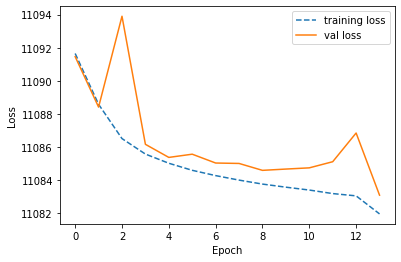

In [6]:
plot_losses(post)

In [7]:
L = store[0][0]['image'].shape[0]

def get_coords(nmbins, L):
    grid = torch.linspace(0,(L-1)/L,L)
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    ms = [torch.full((L*L,), m_i) for m_i in np.linspace(0, 1, 2*nmbins+1)[1::2]]

    coords = [tensor(()).view(1, -1)]
    for m in ms:
        coord = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1)
        coords.append(coord)
    return coords

coords = get_coords(nmbins, L)

In [8]:
net = list(post._ratios.values())[0]
head = net.head.eval()
tail = net.tail.eval()
coord_vu = tail.Map.coord_vu

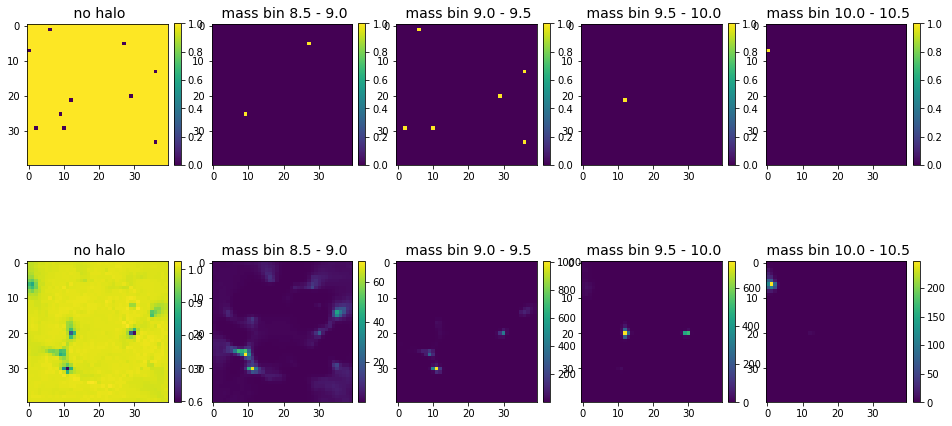

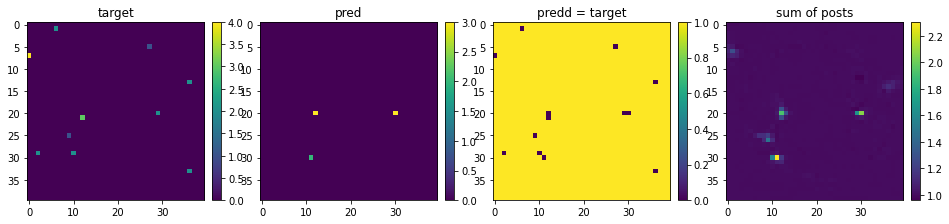

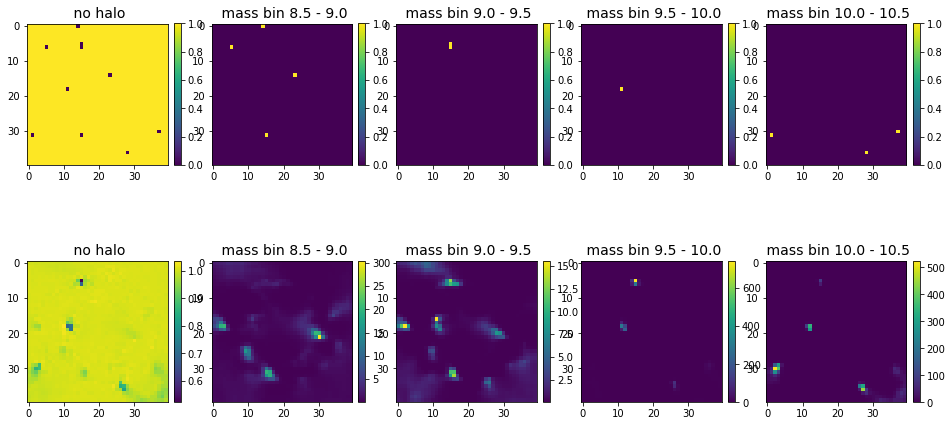

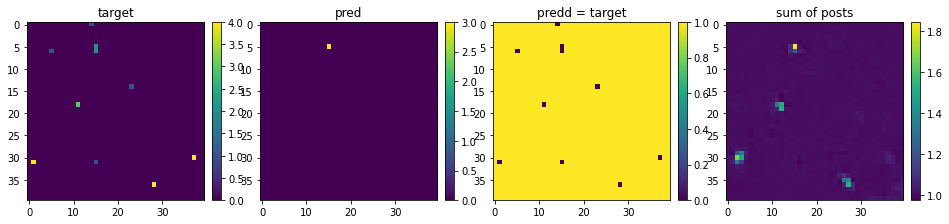

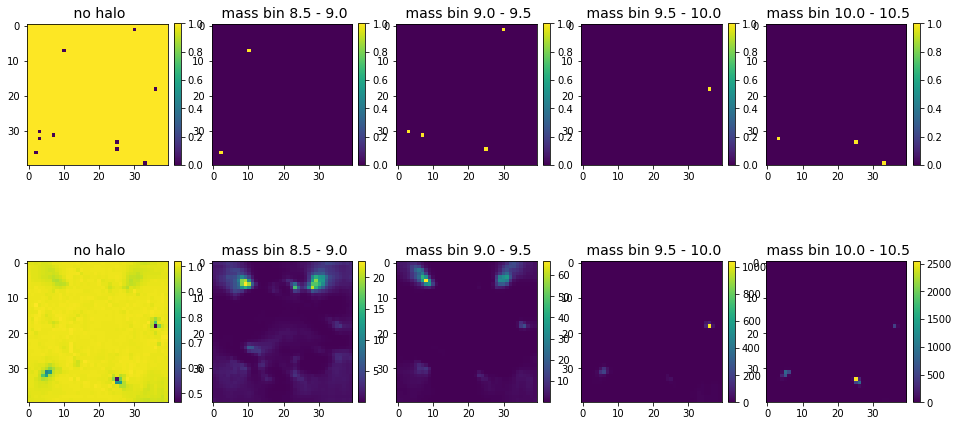

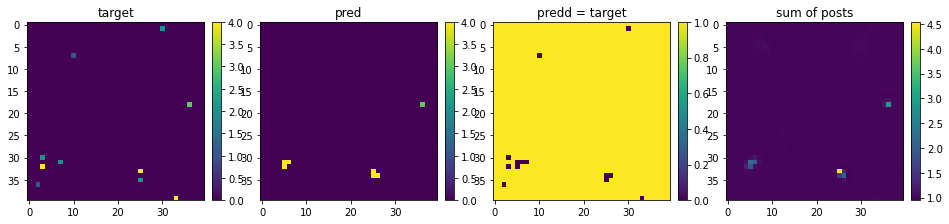

In [106]:
mbins = np.linspace(tail.lows[2], tail.highs[2], nmbins + 1)
title_mbins = [f'mass bin {mbins[i]} - {mbins[i+1]}' for i in range(nmbins)]

for i in np.random.randint(0, len(store), 3):
    obs0 = store[i][0]
    v0 = store[i][1]

    obs0['image'] = tensor(obs0['image']).unsqueeze(0)
    v0 = tensor(v0).unsqueeze(0)

    f = head(obs0).to(DEVICE, dtype = torch.float)

    ratios = np.zeros((nmbins + 1, L, L))
    for i, coord in enumerate(coords):
        params = coord.to(DEVICE, dtype = torch.float)
        logratio = tail(f, params)
        ratio = np.exp(logratio.numpy()).reshape(nmbins + 1, L, L)
        ratios[i] = ratio[i]

    u0 = coord_vu(v0)

    targets = tail.Map.coord_to_map(u0).squeeze().numpy()
    plots = np.concatenate((targets, ratios))
    titles = [f'{j} {i}' for j in ['', ''] 
              for i in ['no halo'] + title_mbins]
    plt_imshow(plots, 2, titles = titles, title_size = 14, cbar = True)

    prior = nsub/(L*L)
    prior0 = 1 - prior
    prior1 = prior/nmbins

    priors = np.concatenate(([prior0], np.tile(prior1, nmbins)))

    posts = ratios * priors[:, np.newaxis, np.newaxis]

    target = np.argmax(targets, axis = 0)
    post   = np.argmax(posts, axis = 0)
    
    plots = [target, post, post == target, np.sum(posts, axis = 0)]
    titles = ['target', 'pred', 'predd = target', 'sum of posts']

    plt_imshow(plots, titles = titles, cbar = True, size_y = 4)
    print()

In [72]:
prior = nsub/(L*L)
prior0 = 1 - prior
prior1 = prior/nmbins

priors = np.concatenate(([prior0], np.tile(prior1, nmbins)))

posts = ratios * priors[:, np.newaxis, np.newaxis]

target = np.argmax(targets, axis = 0)
post   = np.argmax(posts, axis = 0)

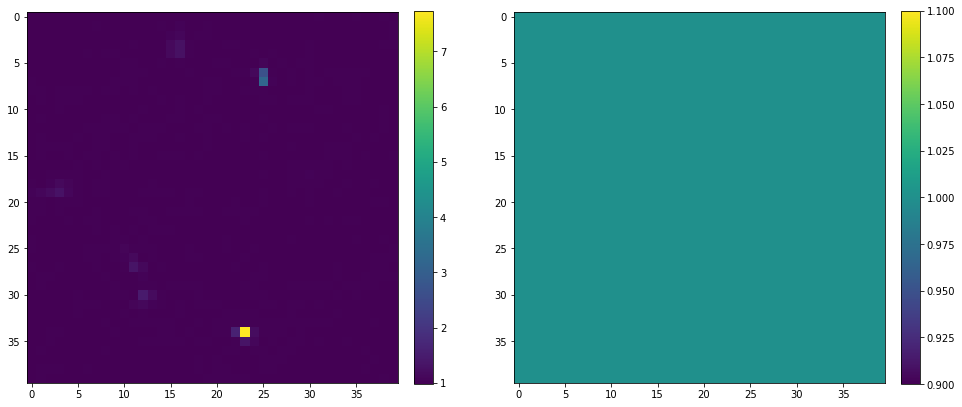

In [80]:
plt_imshow([np.sum(posts, axis = 0), np.sum(targets, axis = 0)], cbar = True)

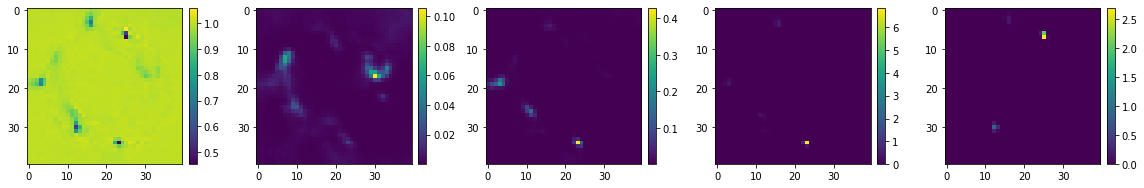

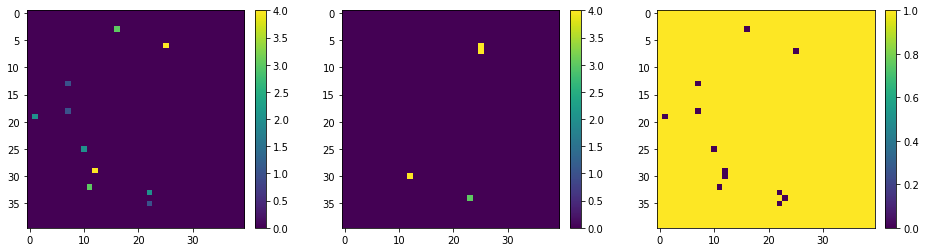

In [90]:
plots = [target, post, post == target]
titles = ['target', 'pred', 'predd = target', ]

plt_imshow(posts, cbar = True, tl = True)
plt_imshow(plots, cbar = True, size_y = 4)

In [2]:
# def get_net(post):
#     re = list(post._ratios.values())[0]
#     head = re.head.eval()
#     tail = re.tail.eval()
#     return head, tail

# head, tail = get_net(post)

# Map = Mapping(nmbins, L)

# re = list(post._ratios.values())[0]

# v0 = store[0][1]
# v0 = tensor(v0).unsqueeze(0)

# re.tail.Map.coord_vu(v0)

# torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
# CONFIG = get_config(system_name, str(nsub), str(m))
# torch.set_default_tensor_type(torch.FloatTensor)


# CONFIG.umodel.alphas["main"].sub.pos_sampler.base_dist.low

# re.tail.Map.coord_vu(v0, lows, highs)

# re.tail